# PW 2 - Bayesian analysis with MRF
For this part we will perform the binary classification of a grayscale image **_Iobservee_** (image of the observations, realization $y$ of the field $Y$) using a Markovian model. 

In this ideal case, we are given the ideal solution $x$ (binary image **_IoriginalBW_**), realization of the field of classes $X$, which will be used to evaluate the quality of the solution $\hat{x}$ that we will have obtained. (NB: In practice usually, we don't have access to $x$). 

In this part we will use the **_display_** function to visualize the images.

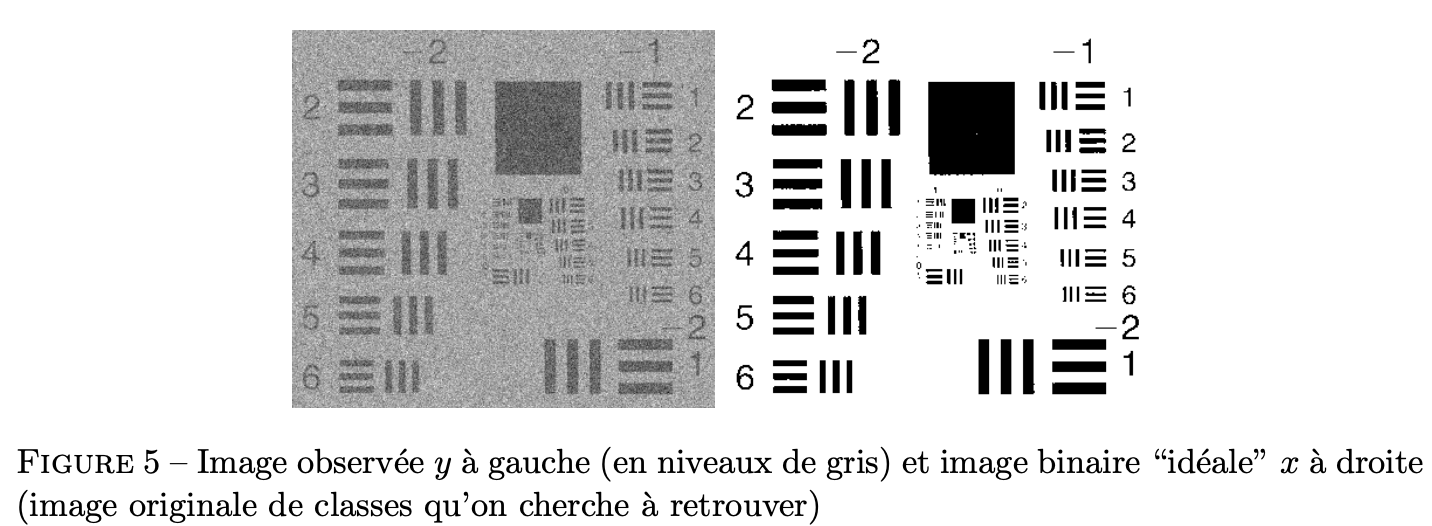

In [1]:
import math
import random
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
import imageio
from scipy import ndimage as ndi
from skimage import io

from bokeh.plotting import figure, output_file, show
from bokeh.plotting import show as showbokeh
from bokeh.io import output_notebook
output_notebook()

In [2]:
def affiche_pour_colab(im,MINI=None, MAXI=None,titre=''): #special colab, don't look
  def normalise_image_pour_bokeh(X,MINI,MAXI):
    if MAXI==None:
      MAXI = np.max(X)
    if MINI==None:
      MINI = np.min(X)
    imt=np.copy(X.copy())
    imt=(np.clip(imt,MINI,MAXI)/(MAXI-MINI))
    imt[imt<0]=0
    imt[imt>1]=1
    imt*=255
    sortie=np.empty((*imt.shape,4),dtype=np.uint8)
    for k in range(3):
      sortie[:,:,k]=imt
    sortie[:,:,3]=255
    return sortie

  img = im
  img=normalise_image_pour_bokeh(np.flipud(im),MINI,MAXI)
  p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")], y_range=[im.shape[0], 0], x_range=[0, im.shape[1]])
  # p.x_range.range_padding = p.y_range.range_padding = 0
  # must give a vector of images
  p.image(image=[np.flipud(im)], x=0, y=im.shape[0], dw=im.shape[1], dh=im.shape[0], palette="Greys9", level="image")
  p.xgrid.visible = False
  p.ygrid.visible = False
  showbokeh(p)

def affiche(im,MINI=0.0, MAXI=None,titre='',printname=False):
  affiche_pour_colab(im,MINI=MINI, MAXI=MAXI,titre=titre) # under google colab many options disappear

The scikit-image library allows to read images from a URL. The "display" function allows to access directly to the grey levels and to the pixels positions by using the mouse.

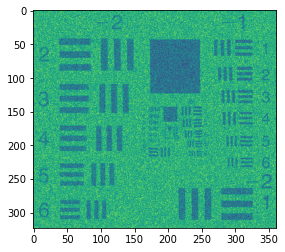

In [3]:
im_obs=io.imread("https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/Iobservee.png")

affiche(im_obs)

In [4]:
im_ori=imageio.imread('https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/IoriginaleBW.png')

affiche(im_ori)

The objective is to estimate $x$ from y using a prior on $P(X)$ in the form of a Markovian model. 
We note $x_s$ the class of the pixel $s$ (that we are looking for), and $y_s$ the observed gray level. The objective is to use a global model on the random field $X$ to classify the image. As we have seen in class, this amounts to minimizing the following energy:

$$U(x|y)=\sum_s -ln(P(Y_s=y_s |X_s=x_s))+\sum_c U_c(x_s, s\in c)$$ 

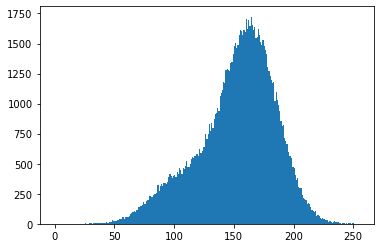

In [5]:
#study of the global distribution of the image
#display of the histogram of the image 
plt.figure()
plt.hist(im_obs.ravel(),range=[0,np.max(im_obs)],bins=np.max(im_obs))
plt.show()

## 1. Analysis of the gray level distributions
In this part, we learn the probabilities $P(Y_s=y_s |X_s)$, that is to say $P(Y_s=y_s |X_s=0)$ and $P(Y_s=y_s |X_s=1)$. This is equivalent to studying the histogram of gray levels of pixels that are in class 0 and pixels that are in class 1.  


To perform this training, we need to select pixels belonging to class 0 on the one hand (dark area of the observed image), and pixels belonging to class 1 on the other hand (light area of the observed image). 

We can select pixels manually, using the command `v0=I[i1:i2,j1:j2]` in Python which puts in a vector all the values of the pixels of the image $I$ included between the indices $i1$ and $i2$ (rows), and $j1$ and $j2$ (columns).

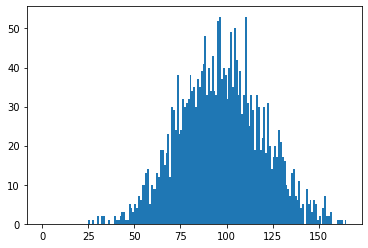

In [6]:
#select a small window in a dark region of the image (class 0)
#be careful, the ordinates correspond to the rows and the abscissas to the columns
crop_classe0=im_obs[50:90,180:240]
#visualise the window
affiche(crop_classe0)
#plot its histogram
plt.figure()
plt.hist(crop_classe0.ravel(),range=[0,np.max(crop_classe0)],bins=np.max(crop_classe0))
plt.show()

In [7]:
#calculate its mean and variance
#
# By default, np.mean, np.zzz takes the two axes of the image. 
# You have to force the option if you want to do the average in row or in column
# use np.mean and np.var
m0= np.mean(crop_classe0)
var0= np.var(crop_classe0)

print(m0)
print(var0)

96.46958333333333
510.4049081597222


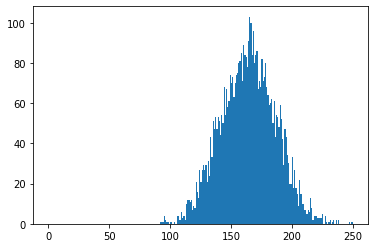

In [8]:
#select a small window in a dark region of the image (class 1)
crop_classe1=im_obs[230:300,130:200]
#visualise the window
affiche(crop_classe0)
#plot its histogram
plt.figure()
plt.hist(crop_classe1.ravel(),range=[0,np.max(crop_classe1)],bins=np.max(crop_classe1))
plt.show()

In [9]:
#calculate its mean and variance
m1= np.mean(crop_classe1)
var1= np.var(crop_classe1)

print(m1)
print(var1)

163.87755102040816
512.7315368596419


### Q1
What are the distributions followed by the grey levels in these two classes? Give the means and variances of the two classes that you have estimated. 

### A1 
(answer on the document)

### Q2
In the following, the variances will be assumed to be equal in order to simplify the energy expressions. 

Suppose that we do not use a Markov model on $X$ and that we classify a pixel only according to its grey level by comparing $P(Y_s=y_s |X_s=0)$ and $P(Y_s=y_s |X_s=1)$. Show that this amounts to thresholding the image and give the value of the optimal threshold as a function of the parameters found previously (we say that we are doing a classification by punctual maximum likelihood).

### A2
(answer on the document)

In [10]:
# Set the threshold for classification in the ML sense and display the image
threshold= (m1+m0)/2
im_bin=im_obs.copy()
im_bin= im_obs >threshold

affiche(im_bin)
plt.show()

###Q3
From the results found for $P(Y_s=y_s |X_s)$, write the likelihood energy (data attachment): $$U_{attdo}=\sum_s -ln(P(Y_s=y_s |X_s=x_s))$$ 

###A3
(answer on the document)

## 2 Ising model for regularisation
To improve the thresholding results, it is necessary to introduce a regularisation (global prior model).

### Q4
Consider the function $\Delta(x_s,x_t)=0$ if $x_s=x_t$, and $\Delta(x_s,x_t)=1$ otherwise. Write the second-order clique potential for this Ising model as a function of $\Delta(x_s,x_t)$ where $x_s$ and $x_t$ are the classes of neighbouring pixels $s$ and $t$ in 4-connexity and the regularisation parameter $\beta$. This model will be 0 when the two neighbouring pixels are equal and $+\beta$ otherwise. 
Write the global energy of the whole field and the local conditional energy for a site 𝑠 using the results previously established for the data attachment energy and the regularization energy defined previously. 

Reminder: the global energy contains all the cliques in the image, the local conditional energy at a site 𝑠 contains only the cliques that contain 𝑠.

Tip: the energy is defined to within one additive constant and one multiplicative constant (the minimum of K+K'U is equivalent to the minimum of U). It is better to simplify the writing of the energy as much as possible in order to do the programming afterwards.

### A4
- _global energy_:

- _local conditional energy_:

(answer on the document)

### Q5
Write the local conditional energies for classes 0 and 1 of the central pixel, using the following local neighbourhood configuration: neighbours in states 0, 1, 1, 1, and assuming that the grey level of the pixel is $y_s=105$, and using the mean and variance values found previously.

### A5
(answer on the document)

### Q6
In which class will this pixel be put if it is assigned the class that locally minimises energy?

### A6
(answer on the document)

### Q7
Considering the ***global*** energy of the field, what is the solution $x$ when $\beta$ is 0 ?

### A7
(answer on the document)

### Q8
Considering the ***global*** energy of the field, what is the solution $x$ when $\beta$ is $+\infty$ ?

### A8
(answer on the document)

### Q9
How will the solution vary when $\beta$ increases ? Comment on the interest of this Markovian model. 

### A9
(answer on the document)

## 3. Optimisation by ICM algorithm
We will optimise the global energy defined above, using the ICM (Iterated Conditional Modes) algorithm which consists of minimising the local conditional energy of the pixels one after the other, starting from a good initialisation of the classes. This algorithm converges to a local minimum but is very fast.  
 
Complete the **iter_icm** function to program the ICM, taking into account the data attachment term you have learned.

### ICM function 
Using what you did for the Gibbs sampler, complete the following function to perform one iteration of the Iterated Conditional Modes algorithm (one pass over all pixels in the image). 

In [11]:
def iter_icm(im_bin,im_toclass,beta_reg,m0,m1):

    i=0;
    j=0;

    for i in range(im_bin.shape[0]):
        for j in range(im_bin.shape[1]):
            # do not change these indices they allow access to neighboring pixels  
            i1=(i-1)%im_bin.shape[0]
            i2=(i+1)%im_bin.shape[0]
            j1=(j-1)%im_bin.shape[1]
            j2=(j+1)%im_bin.shape[1]

            # energy computation if the pixel is put in class 0
            prior_0 = beta_reg * (im_bin[i,j1] + im_bin[i,j2] + im_bin[i1,j] + im_bin[i2,j]) 
            U0= (im_toclass[i,j] - m0)**2 + prior_0

            # energy computation if the pixel is put in class 1
            prior_1 = beta_reg * (4 - im_bin[i,j1] - im_bin[i,j2] - im_bin[i1,j] - im_bin[i2,j]) 
            U1= (im_toclass[i,j] - m1)**2 + prior_1

            if U0 < U1 :
                im_bin[i,j]=0
            else :
                im_bin[i,j]=1

    return im_bin


### Q10
What do you suggest to have a good initialization of the solution? Justify your answer.

###A10
(answer on the document)

Implement the ICM and study the influence of $\beta$.

In [12]:
# ICM algorithm to be implemented
#define the value of beta_reg to have a "good" regularization
beta_reg=2100
#initialise the binary image of the classes 
threshold= (m1+m0)/2
im_bin=im_obs.copy()
im_bin= im_obs > threshold
im_bin.astype(int)
affiche(im_bin)

    
# program a loop in which we call iter_icm 
# and display the class image as iterations are performed 
for n in range(10):  
    im_bin=iter_icm(im_bin,im_obs,beta_reg,m0,m1)
affiche(im_bin)
    


### Q11
With what value of $\beta$ do you get a good solution (i.e. the closest to the given "ideal" image **IoriginaleBW.png**). Compare this result with the result of the optimal thresholding.

### A11
(answer on the document)

You can compare your result with the original image to find the right regularisation parameter. 

In [13]:
#use np.abs to calculate the absolute value of the difference 
# between the original binary image and the ICM result
# note: im_bin is coded between 0 and 1 and im_ori between 0 and 255

for beta_reg in range (1500,3500,200) :
    for n in range(10):  
        im_bin=iter_icm(im_bin,im_obs,beta_reg,m0,m1)
    ima_diff= np.abs(255 * im_bin - im_ori)
    print(n)
    print(beta_reg)
    print(np.mean(ima_diff)) 

9
1500
13.613500510278467
9
1700
13.051465228167372
9
1900
12.9202507654177
9
2100
12.590027700831024
9
2300
12.638139670505904
9
2500
12.498177576906254
9
2700
12.65563493220586
9
2900
12.555037177431112
9
3100
12.931185303980172
9
3300
13.03178305875492


### Q12
Try with other initialisations (with a constant image, with a random image). Comment on their influence.

###A12
(answer on the document)

### Simulated annealing
Program the **echan_r** function of the simulated annealing which allows to update an image by sampling with the Gibbs distribution a posteriori with a fixed temperature T.  

In [14]:
def echan_r(im_bin,im_toclass,beta_reg,m0,m1,T):

    i=0;
    j=0;

    for i in range(im_bin.shape[0]):
        for j in range(im_bin.shape[1]):

            i1=(i-1)%im_bin.shape[0]
            i2=(i+1)%im_bin.shape[0]
            j1=(j-1)%im_bin.shape[1]
            j2=(j+1)%im_bin.shape[1]

            prior_0 = beta_reg*(im_bin[i,j1] + im_bin[i,j2] + im_bin[i1,j] + im_bin[i2,j]) 
            U0= (im_toclass[i,j] - m0)**2 + prior_0
            p0=math.exp(-U0/T);

            prior_1 = beta_reg*(4 - im_bin[i,j1] - im_bin[i,j2] - im_bin[i1,j] - im_bin[i2,j]) 
            U1= (im_toclass[i,j] - m1)**2 + prior_1
            p1=math.exp(-U1/T)

            if p0+p1 != 0 :
                if random.uniform(0,1) < p0/(p0+p1) :
                    im_bin[i,j]= 0
                else :
                    im_bin[i,j]= 1

    return im_bin

Call the function echan_r iteratively, decreasing the temperature after each update slowly enough. 

In [15]:
# Program the simulated annealing 
#temperature initialization 
# initial temperature
T=1000

#initialization of the binary imagethreshold= (m1+m0)/2
im_bin = im_obs.copy()
im_bin = im_obs > threshold
im_bin.astype(int)
affiche(im_bin)

# make a loop by calling the function that does a Gibbs sampling at T
for n in range(10):
    echan_r(im_bin,im_obs,beta_reg,m0,m1,T)
    T=T*0.98
affiche(im_bin)

###Q13
Compare the results obtained by the Iterated Conditional Modes algorithm and by simulated annealing. Do you find the results of the course ?

###A13
(answer on the document)